# Undersampling and oversampling imbalanced data

## Introduction

Oftentimes in practical machine learning problems there will be significant differences in the rarity of different classes of data being predicted. For example, when detecting cancer we can expect to have datasets with large numbers of false outcomes, and a relatively smaller number of true outcomes. 

The overall performance of any model trained on such data will be constrained by its ability to predict rare points. In problems where these rare points are only equally important or perhaps less important than non-rare points, this constraint may only become significant in the later "tuning" stages of building the model. But in problems where the rare points are important, or even the _point_ of the classifier (as in a cancer example), dealing with their scarcity is a first-order concern for the mode builder.

Tangentially, note that the relative importance of performance on rare observations should inform your choice of error metric for the problem you are working on; the more important they are, the more your metric should penalize underperformance on them. See my previous [Model Fit Metrics](https://www.kaggle.com/residentmario/model-fit-metrics/) and [Log Loss](https://www.kaggle.com/residentmario/log-loss-with-new-york-city-building-sales/) notebooks for slightly more detail on which error metrics do and don't care about this problem.

Several different techniques exist in the practice for dealing with imbalanced dataset. The most naive class of techniques is **sampling**: changing the data presented to the model by undersampling common classes, oversampling (duplicating) rare classes, or both.

## Motivation

We'll motivate why under- and over- sampling is useful with an example. The following visualization shows the radical effect that the relative number of points-per-class in a dataset has on classification as performed by a (linear-kernel) Support Vector Machine (for a quick primer on SVMs check [here](https://www.kaggle.com/residentmario/primer-on-support-vector-machines)), shamelessly stolen from the `imbalanced-learn` documentation [here](http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/over-sampling/plot_comparison_over_sampling.html).

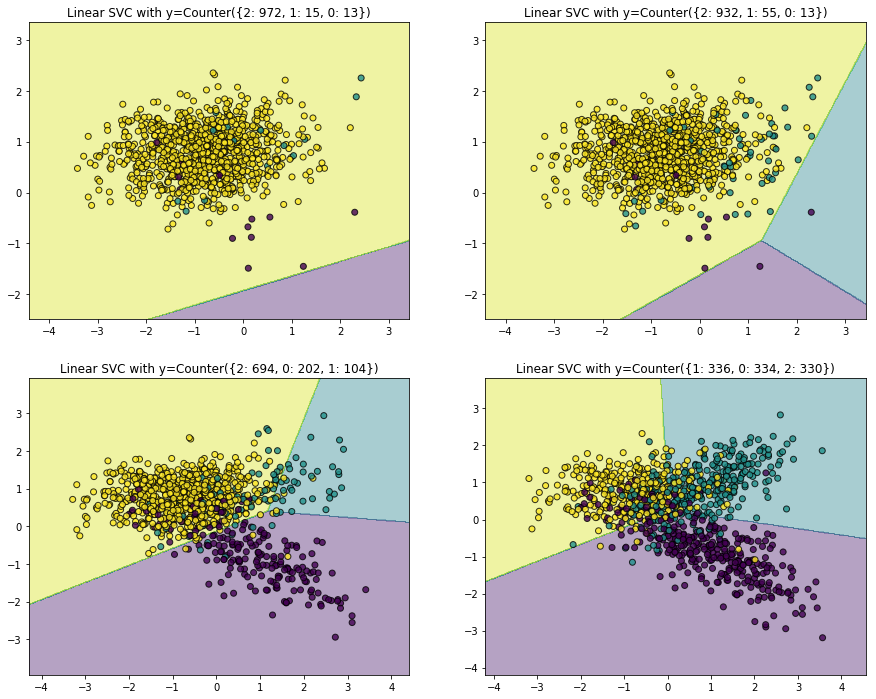

In [1]:
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification

def create_dataset(n_samples=1000, weights=(0.01, 0.01, 0.98), n_classes=3,
                   class_sep=0.8, n_clusters=1):
    return make_classification(n_samples=n_samples, n_features=2,
                               n_informative=2, n_redundant=0, n_repeated=0,
                               n_classes=n_classes,
                               n_clusters_per_class=n_clusters,
                               weights=list(weights),
                               class_sep=class_sep, random_state=0)

def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')
    
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

ax_arr = (ax1, ax2, ax3, ax4)
weights_arr = ((0.01, 0.01, 0.98), (0.01, 0.05, 0.94),
               (0.2, 0.1, 0.7), (0.33, 0.33, 0.33))
for ax, weights in zip(ax_arr, weights_arr):
    X, y = create_dataset(n_samples=1000, weights=weights)
    clf = LinearSVC().fit(X, y)
    plot_decision_function(X, y, clf, ax)
    ax.set_title('Linear SVC with y={}'.format(Counter(y)))

As you can see, when a dataset is dominated by one or few classes, to the exclusion of some other classes, the optimal solution can break down to collapse: a model which simply classifies all or most points in the majority class (as in the first and second visualizations in this grid). However, as the number of observations per point approaches an equal split, the classifier becomes less and less biased.

Re-sampling points that are being fed into the model is the simplest way to fix model errors like this one stemming from rare class problems. Not all datasets have this issue, but for those that due, dealing with this issue is an important early step in modeling the data.

## Getting some sample data

We'll use the following data for the sake of illustration (taken from the `sklearn` documentation):

In [ ]:
import seaborn as sns
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=3,
                           n_clusters_per_class=1,
                           weights=[0.01, 0.05, 0.94],
                           class_sep=0.8, random_state=0)

import matplotlib.pyplot as plt
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y]
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
fig = plt.Figure(figsize=(12,6))
plt.scatter(X[:, 0], X[:, 1], c=colors, **kwarg_params)
sns.despine()

## Raw over- and under- sampling

A group of researchers implemented the full suite of modern data sampling techniques with the `imbalance-learn` contrib module for `sklearn`. This submodule is installed as part of the base `sklearn` install by default, so it should be available to everyone. It comes with its own documentation as well; that is available [here](http://contrib.scikit-learn.org/imbalanced-learn/stable/).

`imblearn` implements over-sampling and under-sampling using dedicated classes.

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
ros = RandomOverSampler(random_state=0)
ros.fit(X, y)
X_resampled, y_resampled = ros.sample(X, y)
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_resampled]
plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=colors, linewidth=0.5, edgecolor='black')
sns.despine()
plt.title("RandomOverSampler Output ($n_{class}=4700)$")
pass

In [ ]:
rus = RandomUnderSampler(random_state=0)
rus.fit(X, y)
X_resampled, y_resampled = rus.sample(X, y)
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_resampled]
plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=colors, linewidth=0.5, edgecolor='black')
sns.despine()
plt.title("RandomUnderSampler Output ($n_{class}=64)$")
pass

In the first graph we have oversampled the dataset, duplicating points from the rare class 2 and the ultra rare class 3 in order to match the common class 1. This results in many points getting "pasted over" a huge number of times, as there are just 64 distinct points in class 2, but 4700 of them in class 1.

In the second graph we have undersampled the dataset. This goes the other way: classes 1 and 2 are reduced in numeric volume until they reach the same number of observations as class 3, at 64.

Which of these two fields of points are you better off training your classifier on? In extreme cases where the number of observations in the rare class(es) is *really* small, oversampling is better, as you will not lose important information on the distribution of the other classes in the dataset. For example, if there were just five observations in class 3, we'd have an awful time training a classifier on just 15 (5 times 3) undersampled points!

Outside of this case however, the performance of the one or the other will be most indistinguishable. Remember, sampling doesn't introduce new information in the dataset, it (hopefully) merely shifts it around so as to increase the "numerical stability" of the resulting models.

In [ ]:
rus = RandomUnderSampler(random_state=0)
rus.fit(X, y)
X_resampled, y_resampled = rus.sample(X, y)
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_resampled]
plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=colors, linewidth=0.5, edgecolor='black')
sns.despine()
plt.title("RandomUnderSampler Output ($n_{class}=64)$")
pass

By default the number of observations will be balanced, e.g. each class will appear equally many times. There's also a `ratio` parameter, which allows you to choose the number of observations per class (in terms of integer absolute numbers, e.g. "60 class 1 observations") to push into your sample dataset. For example:

In [ ]:
rus = RandomUnderSampler(random_state=0, ratio={0: 30, 1: 20, 2: 60})
rus.fit(X, y)
X_resampled, y_resampled = rus.sample(X, y)
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_resampled]
plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=colors, linewidth=0.5, edgecolor='black')
sns.despine()
plt.title("RandomUnderSampler Output ($n_{class}=[30, 20, 60])$")
pass

This resampling technique is useful if the distribution of the classes in your training data differs from the distribution of the classes in the "real world" (and you have a sufficiently large amount of data to have the luxury of "slimming down"). In theory you should not try to work with such data, but in practice this scenario arises often. For example, suppose that you have a dataset of kidney health checks taken from a health clinic, and we are classifying them as health and unhealthy according to some metric. We would naturally expect kidneys from the general population to be healthier, on average, than the one represented in clinical data. For us to succeed in building a generalizable model we would need to resample as a step one!

## Sample size learning curves

In the context of the bias-variance tradeoff, what we hope to achieve by resampling data is to reduce bias, or underfit (recall the clearly one-class-is-the-only-class model from the illustrative example, which is a) more than we increase variance, or overfit (which goes up when decrease the number of input observations or copy-paste points). A way of quantifying this hope is to look at a **learning curve**.

A learning curve illustrates the level of fit of a model as we increase the number of observations we show it. I gave a very brief demo on learning curves in [a previous notebook](https://www.kaggle.com/residentmario/learning-curves-with-zillow-economics-data/), and if you're totally unfamiliar with them I suggest taking a look at that first.

We can generate a learning curve for any sampling method by training a simple model on an incrementally larger number of sampled points, then scoring the resulting model on the full test set. When the performance of the model becomes stable with respect to the number of observations it was trained on, then we have evidence that that's the number of observations we need to include in the sample in order to represent "enough" of the data distribution to not hurt accuracy much.

Here is a simple learning curve built on sampling the data from our synthetic dataset:

In [ ]:
def learning_curve(X, y, observations=range(1, 65)):
    scores = []
    for n in observations:
        rus = RandomUnderSampler(random_state=0, ratio={0: n, 1: n, 2: n})
        rus.fit(X, y)
        X_resampled, y_resampled = rus.sample(X, y)
        score = LinearSVC().fit(X_resampled, y_resampled).score(X, y)
        scores.append(score)
    return scores

plt.plot(range(1, 65), learning_curve(X, y), linewidth=4)
plt.title("RandomUnderSampler Learning Curve", fontsize=16)
plt.gca().set_xlabel("# of Points per Class", fontsize=14)
plt.gca().set_ylabel("Training Accuracy", fontsize=14)
sns.despine()
pass

Here we see that the performance of the model becomes stable around 30 observations per class. This means that the decision boundaries on the Support Vector Machine we train on this sampled data stops moving around (much) some time after the 30-point mark.  which is in turn good evidence that the 64-point `RandomUnderSampler` we've been working with won't introduce significant variance to the model by virtue of having too few points. Hence if under-sampling helps significantly with our rare-point bias problem, it is well worth doing!

Building and checking the sample learning curve is easy and well worth doing. Note that for two-dimensional, normally distributed data like this the number of observations necessary to achieve stability will of course be quite small. In the general case, except stability to require potentally quite a lot of points, certainly more than this.

## Ensemble samplers

The two basic fitting classes we've introduced so far may be combined to generate arbitrarily sized samples. If you want to oversample one class, then undersample some other class, then by running one sampler after the other you can do just that (using the `ratio` argument to fine-tune).

However this can be nitty-gritty. For production `sklearn` provides abstractions on top of these two classes called "ensemble samplers". 

The first and more straightforward of these is `EasyEnsemble`. `EasyEnsemble` can be used to resample features in the dataset naively. An application to our synthetic dataset looks like this:

In [ ]:
from imblearn.ensemble import EasyEnsemble
e = EasyEnsemble(random_state=0, n_subsets=10)
e.fit(X, y)
X_resampled, y_resampled = e.sample(X, y)
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_resampled[0, :]]
plt.scatter(X_resampled[0, :, 0], X_resampled[0, :, 1], c=colors, linewidth=1, edgecolor='black')
sns.despine()

An interesting feature is that `EasyEnsemble` will perform this resampling operation ten times, resulting in ten different sample sets. The plot here is actually showing just the first of these ten different samples. You can change the number of times this is done using the `n_subsets` parameter.

Another thing `EasyEnsemble` allows is sampling with replacement.

By default `EasyEnsemble` is the same as `RandomUnderSampler`, it reduces the counts of each of the classes down to the count of the smallest constituent class. Since class 3 had just 64 observations, we ended up with a sample which has 64 observations per class. This reduces the shape of our dataset from `(5000, 2)` way down to `(192, 2)` per sample. The API for adjusting this is the same: use the `ratio` parameter, passing in a `dict` with the desired number of observations per class.

However, I find the `EasyEnsemble` API hard to use, because it doesn't allow automatically combining oversampling with undersampling, e.g. oversampling one category and undersampling another. There is however one `EasyEnsemble` feature that is not available in the raw sampler methods, which is sampling with replacement (`replacement=True`). I'm dubious as to the utility of this feature, but it exists.

The other method you can use is `BalanceCascade`. `BalanceCascade` is a computational adaptation of `EasyEnsemble`. You feed it an estimator, and that estimator is used to predict output classes. When observations from the dataset are sampled, observations which are misclassified are replaced in the dataset, and those which aren't are not. The end result is a set of samples biased towards (duplicated) poorly classifiable observations.

`EasyEsnemble` allows you to over/under-sample with or without replacement, `BalanceCascade` allows you to over/under-sample with smart replacement (at least that's what the `sklearn` documentation calls this technique). This is an interesting resampling technique if you are interested in working on problem point performance while working with rare classes. It allows you to, in a sense, test the numerical stability of the classifier you have built, by re-training it on a set of points that it is known to have trouble with (and then checking the difference).

I again find this API difficult-to-use, however.

In [ ]:
from imblearn.ensemble import BalanceCascade
from sklearn.linear_model import LogisticRegression
bc = BalanceCascade(random_state=0,
                    estimator=LogisticRegression(random_state=0),
                    n_max_subset=10)
bc.fit(X, y)
X_resampled, y_resampled = bc.sample(X, y)
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_resampled[0, :]]
plt.scatter(X_resampled[0, :, 0], X_resampled[0, :, 1], c=colors, linewidth=1, edgecolor='black')
sns.despine()

## Application

So far we've motivated the case for sampling your data and introduced under- and over- sampling facilities in `sklearn`. Next let's look at an application. 

For ease of visualization let's initially treat the first two predictor columns, `V1` and `V2`, only.

In [ ]:
import pandas as pd
df = pd.read_csv("../input/creditcard.csv")
df.head()

In [ ]:
df['Class'].value_counts()

Credit card fraud events are rare, so training a good model on this dataset should involve thinking about this class imbalance.

Left to its own devices, a Support Vector Machine will pretty much collapse, failing to find *any* meaningful axis in the data:

In [ ]:
X = df[df.columns[:-1]].values
y = df['Class'].values

In [ ]:
ax = plt.gca()
plot_decision_function(X[:, :2][:1000], y[:1000], LinearSVC().fit(X[:, :2][:5000], y[:5000]), ax)

If we resampled this data, a more meaningful pattern emerges. It appears that transactions that load heavily in `V2` are almost always fradulent:

In [ ]:
rus = RandomUnderSampler(random_state=0)
rus.fit(X, y)
X_resampled, y_resampled = rus.sample(X, y)
colors = ['white' if v == 0 else 'black' if v == 1 else '#67a9cf' for v in y_resampled]
plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=colors, linewidth=0.5, edgecolor='black')
sns.despine()
plt.title("RandomUnderSampler Output")
pass

If we train the SVM on this resampled data, the algorithm will now "realize" this and pick a separating hyperplane that takes this fact into account:

In [ ]:
ax = plt.gca()
plot_decision_function(X[:, :2][:1000], y[:1000], LinearSVC().fit(X_resampled[:, :2], y_resampled), ax)

Suppose you are designing an "early warning" system that quarantines transactions which might be fradulent for additional checks in the system. Suppose that after market research and cost analysis, your analysts have determined that a 50:1 ratio of false positives to true positives is "worth it". We could implement a custom classification metric to reflect this. We would find that in this (admittedly made-up, but reasonably realistic) cost environment, the price of the post-sampling model is near that of the pre-processing model, even though we're misclassifying a hella lot of legit records:

In [ ]:
def costed_error(y, y_hat):
    sum_error = 0
    for _y, _y_hat in zip(y, y_hat):
        if _y != _y_hat:
            n = 1 if _y == 0 else 50
            sum_error += n
    return sum_error

In [ ]:
clf_pre = LinearSVC().fit(X[:1000], y[:1000])
clf_post = LinearSVC().fit(X_resampled, y_resampled)

In [ ]:
costed_error(y, clf_pre.predict(X))

In [ ]:
costed_error(y, clf_post.predict(X))

<!-- Whilst the recall score&mdash;the percentage of fradulent records that get flagged by this system&mdash;goes from basically zero to close to 60 percent!

from sklearn.metrics import recall_score
idx = np.where(y == 1)
y_fraud = y[idx]
y_fraud_hat_pre = clf_pre.predict(X)[idx]
y_fraud_hat_post = clf_post.predict(X)[idx]
recall_score(y_fraud, y_fraud_hat_pre)
recall_score(y_fraud, y_fraud_hat_post)

-->

## Conclusion

In this notebook we learned about over- and under- sampling: what they are and what problems they solve; some implementations in `sklearn`; and a simple application to a credit card fradulent transaction detection problem.

Under- and over- sampling are just the two simplest sampling strategies, and sampling strategies are in turn just the simplest way of dealing with class imbalance problems. Other approaches to class imbalance problems include custom error functions (designing your own kernel for the SVM for instance), and other approaches to sampling include more involved algorithms like SMOTE and other toys. I plan on covering some of this in later notebooks.

Interested in learning more about sampling? The `imbalanced-learn` documentation (http://contrib.scikit-learn.org/imbalanced-learn/stable/index.html) is a great resource and reference on 